In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from statsmodels.stats.power import TTestIndPower
from scipy import stats

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_file
from bokeh.layouts import row, column, gridplot
from bokeh.models import ColumnDataSource, Legend, BoxAnnotation, HoverTool, Plot, FactorRange, TapTool, OpenURL, Range1d
from bokeh.models.widgets import Tabs, Panel

In [2]:
!wget "https://docs.google.com/spreadsheets/d/1O8YItuJ4CtaFFEXbjBcxvhUoM7v9AX1uFDRMhh7iQZM/export?format=xlsx" -O "metadata.xlsx"

--2022-12-26 13:30:37--  https://docs.google.com/spreadsheets/d/1O8YItuJ4CtaFFEXbjBcxvhUoM7v9AX1uFDRMhh7iQZM/export?format=xlsx
Resolving docs.google.com (docs.google.com)... 142.251.214.142
Connecting to docs.google.com (docs.google.com)|142.251.214.142|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-14-5g-sheets.googleusercontent.com/export/8hg3b1ek8ops3o87ml9dh1hpus/48421srnje8aupl4191jpnj1h0/1672090235000/102025844088317935117/*/1O8YItuJ4CtaFFEXbjBcxvhUoM7v9AX1uFDRMhh7iQZM?format=xlsx [following]
--2022-12-26 13:30:37--  https://doc-14-5g-sheets.googleusercontent.com/export/8hg3b1ek8ops3o87ml9dh1hpus/48421srnje8aupl4191jpnj1h0/1672090235000/102025844088317935117/*/1O8YItuJ4CtaFFEXbjBcxvhUoM7v9AX1uFDRMhh7iQZM?format=xlsx
Resolving doc-14-5g-sheets.googleusercontent.com (doc-14-5g-sheets.googleusercontent.com)... 142.251.46.161
Connecting to doc-14-5g-sheets.googleusercontent.com (doc-14-5g-sheets.googleusercontent.com)|142.251.

In [3]:
data = pd.read_excel('metadata.xlsx', sheet_name='WearableBP Paper Metadata')

In [4]:
pd.DataFrame(data[data['Include'] == 0]['Exclude Reason'].value_counts())

,Exclude Reason
irrelevant,899
record level split without personalization,192
duplicate,190
review,98
no reported MAE/ME,97
...,...
record level split without personalization; finds correlations between PAT and SBP,1
no experiment on humans; hardware development,1
irrelevant; investigates STI intervals,1
record level split without personalization; no reported MAE/ME; calibrate and immediately test,1


In [5]:
import nltk
from rake_nltk import Rake
nltk.download('stopwords')

def find_keywords(x, include_columns):
    s = ''
    for col in include_columns:
        if x[col] != x[col]:
            pass
        else:
            s += ' ' + str(x[col])
            
    rake_nltk_var = Rake()
    rake_nltk_var.extract_keywords_from_text(s)
    keywords = rake_nltk_var.get_ranked_phrases()
    return ' '.join(keywords)

include_columns = ['Authors', 'Title', 'Source', 'Exclude Reason', 'Key Devices and Measurements', 'Calibration Technique', 'Algorithm', 'Dataset', 'Training Subject Characteristics', 'Testing Subject Characteristics', 'Study Characteristics','Evaluation Metric', 'Notes', 'Abstract']
data['Keywords'] = data.apply(find_keywords, axis=1, args=(include_columns, ))

[nltk_data] Downloading package stopwords to /Users/matt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
a = data.copy().dropna(subset='Exclude Reason')
len(a[a['Exclude Reason'].str.contains('record level split without personalization')])

330

In [7]:
def compress_authors(x):
    a = x.split(',')[0].split(' ')
    if len(a) == 1:
        return a[0]
    elif len(a) == 2:
        return a[1]
    elif len(a) == 3:
        return a[2]
    else:
        return a[-1]

df = data.copy()
df = df[(df['Include'] == 1) & (df['BP Distribution Type'] == 'ME') & ((df['Evaluation Metric'] == 'MAE') | (df['Evaluation Metric'] == 'ME'))]

df['Sensor Data'] = df['Key Devices and Measurements'].str.split(';', expand=True)[0]
df['Calibration Technique'] = df['Calibration Technique'].str.split(';', expand=True)[0]
df['Algorithm'] = df['Algorithm'].str.split(';', expand=True)[0]
df['Dataset'] = df['Dataset'].str.split(';', expand=True)[0]
df['Testing Subject Characteristics'] = df['Testing Subject Characteristics'].str.split(';', expand=True)[0]
df['Study Characteristics'] = df['Study Characteristics'].str.split(';', expand=True)[0]
df['Algorithm'] = df['Algorithm'].str.split(';', expand=True)[0]
df['SBP Distribution Raw'] = df['BP Distribution'].str.split(';', expand=True)[0]
df['SBP Distribution STD'] = df['SBP Distribution Raw'].str.split('±', expand=True)[1].astype(float)
df['DBP Distribution Raw'] = df['BP Distribution'].str.split(';', expand=True)[1]
df['DBP Distribution STD'] = df['DBP Distribution Raw'].str.split('±', expand=True)[1].astype(float)
df['SBP Reported Error Raw'] = df['Reported Result'].str.split(';', expand=True)[0]
df['DBP Reported Error Raw'] = df['Reported Result'].str.split(';', expand=True)[1]

In [8]:
df_mae = df[df['Evaluation Metric'] == 'MAE']
df_mae['SBP Error STD'] = df_mae['SBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
df_mae['DBP Error STD'] = df_mae['DBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
df_me = df[df['Evaluation Metric'] == 'ME']
df_me['SBP Error STD'] = df_me['SBP Reported Error Raw'].str.split('±', expand=True)[1].astype(float)
df_me['DBP Error STD'] = df_me['DBP Reported Error Raw'].str.split('±', expand=True)[1].astype(float)
df_concat = pd.concat([df_me, df_mae], axis=0)
df_concat['SBP ED'] = df_concat['SBP Distribution STD']/df_concat['SBP Error STD']
df_concat['DBP ED'] = df_concat['DBP Distribution STD']/df_concat['DBP Error STD']

df_concat['SBP ED 95CI UB'] = df_concat.apply(lambda x: np.sqrt(stats.f.isf(0.05/2, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['SBP ED'], axis=1)
df_concat['SBP ED 95CI LB'] = df_concat.apply(lambda x: np.sqrt(stats.f.isf(1-0.05/2, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['SBP ED'], axis=1)
df_concat['SBP ED MOE'] = (df_concat['SBP ED 95CI UB'] - df_concat['SBP ED 95CI LB'])/2
df_concat['DBP ED 95CI UB'] = df_concat.apply(lambda x: np.sqrt(stats.f.isf(0.05/2, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['DBP ED'], axis=1)
df_concat['DBP ED 95CI LB'] = df_concat.apply(lambda x: np.sqrt(stats.f.isf(1-0.05/2, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['DBP ED'], axis=1)
df_concat['DBP ED MOE'] = (df_concat['DBP ED 95CI UB'] - df_concat['DBP ED 95CI LB'])/2

df_concat['Authors'] = df_concat['Authors'].apply(compress_authors) + ' et al.'
compute_power = lambda x: TTestIndPower().solve_power(5/8, ratio=1, alpha=0.05, nobs1=x, power=None, alternative='two-sided')
df_concat['Power'] = df_concat['Number of Test Subjects'].apply(compute_power)
# 2*((stats.norm.isf(1-0.05/2) + stats.norm.isf(1-0.02))/(5/8))**2
# 1-stats.norm.sf(np.sqrt(85/2)*(5/8)-stats.norm.ppf(1-0.05/2))

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/4128608041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mae['SBP Error STD'] = df_mae['SBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/4128608041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mae['DBP Error STD'] = df_mae['DBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/4128608041.py:5: Set

In [9]:
save_cols = ['Title', 'ArticleURL', 'Authors', 'Year', 'Calibration Technique', 'Sensor Data', 'Algorithm', 'Dataset', 'Number of Test Subjects', 'Testing Subject Characteristics', 'Study Characteristics', 'SBP Distribution STD', 'DBP Distribution STD', 'SBP ED', 'DBP ED', 'SBP ED MOE', 'DBP ED MOE', 'Power', 'Original Model Implementation Availability', 'Original Model Implementation Link', 'Exact Dataset/Pre-processing Code Availability', 'Exact Dataset/Pre-processing Code Link']

def make_clickable(name, url):
    return '<a href="' + url + '">' + name + '</a>'

save_table = df_concat.copy()[save_cols]
save_table['Title'] = make_clickable(save_table['Title'] + ' (' + save_table['Authors'] + ', '+ save_table['Year'].astype(int).astype(str) + ')', save_table['ArticleURL'])
save_table.drop(['Year'], axis=1, inplace=True)
save_table.drop(['Authors'], axis=1, inplace=True)
save_table.drop(['ArticleURL'], axis=1, inplace=True)

save_table['Original Model Implementation Availability'] = make_clickable(save_table['Original Model Implementation Availability'], save_table['Original Model Implementation Link'])
save_table['Exact Dataset/Pre-processing Code Availability'] = make_clickable(save_table['Exact Dataset/Pre-processing Code Availability'], save_table['Exact Dataset/Pre-processing Code Link'])
save_table.drop(['Original Model Implementation Link', 'Exact Dataset/Pre-processing Code Link'], axis=1, inplace=True)

sls_save_table = save_table[save_table['Calibration Technique'] == 'subject level split']
per_save_table = save_table[save_table['Calibration Technique'] == 'personalization']

save_table.to_html('./_includes/include_table.html', index=False, render_links=True, table_id='itable', escape=False)
sls_save_table.to_html('./_includes/include_sls_table.html', index=False, render_links=True, table_id='islstable', escape=False)
per_save_table.to_html('./_includes/include_per_table.html', index=False, render_links=True, table_id='ipertable', escape=False)

In [10]:
len(sls_save_table), len(per_save_table)

(60, 10)

In [11]:
cat_columns = ['Sensor Data', 'Algorithm', 'Dataset', 'Testing Subject Characteristics', 'Study Characteristics']
cont_columns = ['Number of Test Subjects', 'SBP Distribution STD', 'DBP Distribution STD', 'SBP ED', 'DBP ED', 'Power']

tooltips = [("% of subject level split", "@{subject level split pct}"), 
            ("% of personalization", "@{personalization pct}")]

ps = []
for c in cat_columns:
    d = pd.DataFrame(save_table[[c, 'Calibration Technique']].value_counts()).reset_index().rename({0: 'Count'}, axis=1).pivot(index=c, columns='Calibration Technique', values='Count').reset_index().fillna(0)
    d['subject level split pct'] = d['subject level split']/d['subject level split'].sum()*100
    d['personalization pct'] = d['personalization']/d['personalization'].sum()*100
    source = ColumnDataSource(d)
    p = Plot(title=None, width=800, height=600, toolbar_location=None)
    p = figure(y_range=FactorRange(factors=d[c].unique()), plot_width=1000, plot_height=400, title='',
                toolbar_location=None, tooltips=tooltips, tools = [])
    p.hbar_stack(['subject level split', 'personalization'], y=c, source=source, fill_color=['red', 'blue'])
    p.x_range = Range1d(0, (d['subject level split']+d['personalization']).max())
    p.xaxis.axis_label = c
    p.yaxis.axis_label = 'Count'
    ps.append(p)

for c in cont_columns:
    d = save_table[[c, 'Calibration Technique']]
    d1 = d[d['Calibration Technique'] == 'subject level split'].dropna()
    d2 = d[d['Calibration Technique'] == 'personalization'].dropna()
    p1 = figure(title=c + ' (Subject Level Split)', width=500, height=400, min_border=0, tools='', background_fill_color="#fafafa", toolbar_location='above')
    p2 = figure(title=c + ' (Personalization)', width=500, height=400, min_border=0, tools=[], background_fill_color="#fafafa", toolbar_location='above')
    hist1, edge1 = np.histogram(d1[c], bins=10)
    hist2, edge2 = np.histogram(d2[c], bins=10)
    p1.quad(top=hist1, bottom=0, fill_color='red', line_color="white", alpha=0.5, left=edge1[:-1], right=edge1[1:])
    p2.quad(top=hist2, bottom=0, fill_color='blue', line_color="white", alpha=0.5, left=edge2[:-1], right=edge2[1:])
    
    p1.y_range = Range1d(0, hist1.max())
    p1.xaxis.axis_label = c
    p1.yaxis.axis_label = 'Count'
    p2.y_range = Range1d(0, hist2.max())
    p2.xaxis.axis_label = c
    p2.yaxis.axis_label = 'Count'
    p = row(p1, p2)
    ps.append(p)
    
# tabs = []
# for i in range(len(cat_columns)):
#     tabs.append(Panel(child=ps[i], title=cat_columns[i]))
# for i in range(len(cont_columns)):
#     tabs.append(Panel(child=ps[len(cat_columns)+i], title=cont_columns[i]))
# figure_tabs = Tabs(tabs=tabs)

# output_file('./_includes/metadata_stats.html')
# show(figure_tabs)

In [12]:
output_file('./_includes/metadata_stats_grid.html')
grid = gridplot([[ps[0], ps[1]], [ps[2], ps[3]],
                 [ps[4], ps[5]], [ps[6], ps[7]],
                 [ps[8], ps[9]], [ps[10], None]], width=1000, height=600)
grid.spacing = 0

In [13]:
show(grid)

In [14]:
cat_columns = ['Sensor Data', 'Algorithm', 'Dataset', 'Study Characteristics']

tooltips = [("% of subject level split", "@{subject level split pct}"), 
            ("% of personalization", "@{personalization pct}")]

ps = []
for c in cat_columns:
    d = pd.DataFrame(save_table[[c, 'Calibration Technique']].value_counts()).reset_index().rename({0: 'Count'}, axis=1).pivot(index=c, columns='Calibration Technique', values='Count').reset_index().fillna(0)
    d['subject level split pct'] = d['subject level split']/d['subject level split'].sum()*100
    d['personalization pct'] = d['personalization']/d['personalization'].sum()*100
    source = ColumnDataSource(d)
    p = Plot(title=None, width=800, height=600, toolbar_location=None)
    p = figure(y_range=FactorRange(factors=d[c].unique()), plot_width=1000, plot_height=400, title='',
                toolbar_location=None, tooltips=tooltips, tools = [])
    p.hbar_stack(['subject level split', 'personalization'], y=c, source=source, fill_color=['red', 'blue'])
    p.x_range = Range1d(0, (d['subject level split']+d['personalization']).max())
    p.xaxis.axis_label = c
    p.yaxis.axis_label = 'Count'
    ps.append(p)

for c in cont_columns:
    d = save_table[[c, 'Calibration Technique']]
    d1 = d[d['Calibration Technique'] == 'subject level split'].dropna()
    d2 = d[d['Calibration Technique'] == 'personalization'].dropna()
    p1 = figure(title=c + ' (Subject Level Split)', width=500, height=400, min_border=0, tools='', background_fill_color="#fafafa", toolbar_location='above')
    p2 = figure(title=c + ' (Personalization)', width=500, height=400, min_border=0, tools=[], background_fill_color="#fafafa", toolbar_location='above')
    hist1, edge1 = np.histogram(d1[c], bins=10)
    hist2, edge2 = np.histogram(d2[c], bins=10)
    p1.quad(top=hist1, bottom=0, fill_color='red', line_color="white", alpha=0.5, left=edge1[:-1], right=edge1[1:])
    p2.quad(top=hist2, bottom=0, fill_color='blue', line_color="white", alpha=0.5, left=edge2[:-1], right=edge2[1:])
    
    p1.y_range = Range1d(0, hist1.max())
    p1.xaxis.axis_label = c
    p1.yaxis.axis_label = 'Count'
    p2.y_range = Range1d(0, hist2.max())
    p2.xaxis.axis_label = c
    p2.yaxis.axis_label = 'Count'
    p = row(p1, p2)
    ps.append(p)
    
# tabs = []
# for i in range(len(cat_columns)):
#     tabs.append(Panel(child=ps[i], title=cat_columns[i]))
# for i in range(len(cont_columns)):
#     tabs.append(Panel(child=ps[len(cat_columns)+i], title=cont_columns[i]))
# figure_tabs = Tabs(tabs=tabs)

# output_file('./_includes/metadata_stats.html')
# show(figure_tabs)

In [15]:
output_file('./_includes/metadata_stats_paperfig.html')
grid = gridplot([[ps[0], ps[1]], [ps[2], ps[3]]], width=1000, height=600)
grid.spacing = 1

In [16]:
from bokeh.io import export_png
export_png(grid, filename='./_includes/metadata_stats_paperfig.png')

'/Users/matt/Documents/GRAD_SCHOOL/wearablebp.github.io/_includes/metadata_stats_paperfig.png'

In [17]:
meetspecs_sls = sls_save_table[(sls_save_table['Power'] > 0.98) & (sls_save_table['SBP ED'] > 2.17) & (sls_save_table['DBP ED'] > 1.39)]
meetspecs_sls['SBP ED 95CI LB'] = meetspecs_sls.apply(lambda x: np.sqrt(stats.f.isf(1-0.1, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['SBP ED'], axis=1)
meetspecs_sls['DBP ED 95CI LB'] = meetspecs_sls.apply(lambda x: np.sqrt(stats.f.isf(1-0.1, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['DBP ED'], axis=1)
meetspecs_cols = ['Title', 'Sensor Data', 'Calibration Technique', 'Algorithm', 'Dataset', 'SBP ED', 'DBP ED', 'SBP ED 95CI LB', 'DBP ED 95CI LB']
for col in meetspecs_sls.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns:
    meetspecs_sls[col] = np.round(meetspecs_sls[col], 2)
meetspecs_sls[meetspecs_cols].to_html('./_includes/meetspecs_sls_table.html', index=False, render_links=True, table_id='mslstable', escape=False)

# per_save_table[(per_save_table['Power'] > 0.98) & (per_save_table['SBP ED'] - per_save_table['SBP ED MOE'] > 2.17) & (per_save_table['DBP ED'] - per_save_table['DBP ED MOE'] > 1.39)]

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/2121789591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meetspecs_sls['SBP ED 95CI LB'] = meetspecs_sls.apply(lambda x: np.sqrt(stats.f.isf(1-0.1, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['SBP ED'], axis=1)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/2121789591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meetspecs_sls['DBP ED 95CI LB'] = meetspecs_sls.apply(lambda x: np.sqrt(stats.f.i

In [18]:
# get exclude table
exclude_table = data[data['Include'] == 0]
exclude_table['Year'] = exclude_table['Year'].fillna(0)
exclude_table['Authors'] = exclude_table['Authors'].fillna('Not Available')
exclude_table['Title'] = make_clickable(exclude_table['Title'] + ' ' + exclude_table['Year'].astype(int).astype(str), exclude_table['ArticleURL'])
exclude_table['Authors'] = exclude_table['Authors'].apply(compress_authors) + ' et al.'
exclude_table = exclude_table[['Title', 'Authors', 'Exclude Reason']]
exclude_table.to_html('./_includes/exclude_table.html', index=False, render_links=True, table_id='etable', escape=False)

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/2903807737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_table['Year'] = exclude_table['Year'].fillna(0)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/2903807737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_table['Authors'] = exclude_table['Authors'].fillna('Not Available')
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/2903807737.py:5: SettingWithCopyWarning: 
A value is trying to

In [19]:
hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 20px"> @{Hover Title} </span> <br>
                <span style="font-size: 10px"> @{Title} </span> <br>
                <span style="font-size: 10px"> Sensor Data: @{Sensor Data}</span> <br>
                <span style="font-size: 10px"> SBP/DBP Reported Result (mmHg): @{SBP Reported Error Raw} /  @{DBP Reported Error Raw} </span> <br>
                <span style="font-size: 10px"> SBP Explained Deviation: @{SBP ED}</span> <br>
                <span style="font-size: 10px"> DBP Explained Deviation: @{DBP ED}</span> <br>
                <span style="font-size: 10px"> SBP Distribution STD: @{SBP Distribution STD} mmHg </span> <br>
                <span style="font-size: 10px"> DBP Distribution STD: @{DBP Distribution STD} mmHg </span> <br>
                <span style="font-size: 10px"> Power: @{Power}</span> <br>
                <span style="font-size: 10px"> Number of Test Subjects: @{Number of Test Subjects}</span> <br>
                <span style="font-size: 10px"> Study Characteristics: @{Study Characteristics}</span>
            </div>
        </div>
        """
    )
cs = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']

In [20]:
output_file('./_includes/scatter.html')

p1 = figure(title='Subject Level Split', background_fill_color="#fafafa", width=400, height=400, toolbar_location='above', tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p1.xaxis.axis_label = 'DBP Explained Deviation'
p1.yaxis.axis_label = 'SBP Explained Deviation'
p2 = figure(title='Personalization', background_fill_color="#fafafa", width=625, height=400, toolbar_location='above', tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p2.xaxis.axis_label = 'DBP Explained Deviation'
p2.yaxis.axis_label = 'SBP Explained Deviation'

box = BoxAnnotation(bottom=2.17, left=1.39, fill_alpha=0.05, fill_color='green', line_width=5, line_dash = 'dashed', line_color='green', line_alpha=0.05)
p1.add_layout(box)
p2.add_layout(box)

plot_df = df_concat.copy()

colors = {}
u_sd = plot_df['Sensor Data'].unique()
for i in range(len(u_sd)):
    colors[u_sd[i]] = cs[i]
plot_df['Color'] = [colors[i] for i in plot_df['Sensor Data']]
plot_df['Size'] = plot_df['Power']*15
plot_df['Hover Title'] = plot_df['Authors'] + ' (' + plot_df['Year'].astype(int).astype(str) + ')'

legend_it = []
for i in range(len(u_sd)):
    d1 = plot_df[plot_df['Sensor Data'] == u_sd[i]]
    sls = d1[d1['Calibration Technique'] == 'subject level split']
    per = d1[d1['Calibration Technique'] == 'personalization']
    c1 = p1.scatter('DBP ED', 'SBP ED', source=ColumnDataSource(sls), fill_alpha=0.4, size='Size', color='Color', muted_alpha=0)
    c2 = p2.scatter('DBP ED', 'SBP ED', source=ColumnDataSource(per), fill_alpha=0.4, size='Size', color='Color', muted_alpha=0)
    c3 = p2.scatter('DBP ED', 'SBP ED', source=ColumnDataSource(sls), fill_alpha=0.4, size='Size', color='Color', muted_alpha=0, visible = False)
    taptool1 = p1.select(type=TapTool)
    taptool1.callback = OpenURL(url='@ArticleURL')
    taptool2 = p2.select(type=TapTool)
    taptool2.callback = OpenURL(url='@ArticleURL')
    legend_it.append((u_sd[i], [c1, c2, c3]))
    legend = Legend(items=legend_it)
    legend.click_policy='mute'
p2.add_layout(legend, 'right')
# p1.add_layout(legend, 'right')


show(row([p1, p2]))

In [21]:
save_cols = ['Title', 'Authors', 'ArticleURL', 'Year', 'Sensor Data', 'Number of Test Subjects', 'Dataset', 'Calibration Technique', 'SBP ED', 'DBP ED', 'Original Model Implementation Availability', 'Original Model Implementation Link', 'Exact Dataset/Pre-processing Code Availability', 'Exact Dataset/Pre-processing Code Link', 'wearablebp.github.io Implementation Result']
availability_table = df_concat.copy()[save_cols]
availability_table['Title'] = make_clickable(availability_table['Title'] + ' (' + availability_table['Authors'] + ', ' + availability_table['Year'].astype(int).astype(str) + ')', availability_table['ArticleURL'])
# availability_table.drop('ArticleURL', axis=1, inplace=True)

availability_table['Original Model Implementation Availability'] = make_clickable(availability_table['Original Model Implementation Availability'], availability_table['Original Model Implementation Link'])
availability_table['Exact Dataset/Pre-processing Code Availability'] = make_clickable(availability_table['Exact Dataset/Pre-processing Code Availability'], availability_table['Exact Dataset/Pre-processing Code Link'])

availability_table[['Title', 'Sensor Data', 'Dataset', 'Calibration Technique', 'SBP ED', 'DBP ED', 'Original Model Implementation Availability', 'Exact Dataset/Pre-processing Code Availability', ]].rename({'SBP ED':'Reported SBP ED', 'DBP ED': 'Reported DBP ED'}, axis=1).to_html('./_includes/availability_table.html', index=False, render_links=True, table_id='atable', escape=False)

In [22]:
def convert_dt(x):
    if 's' in x:
        if x.split('s')[0] == '0':
            return 0
        return np.log10(int(x.split('s')[0]))+0
    elif 'm' in x:
        return np.log10(int(x.split('m')[0]))+1
    elif 'h' in x:
        return np.log10(int(x.split('h')[0]))+2
    elif 'd' in x:
        return np.log10(int(x.split('d')[0]))+3
    elif 'mon' in x:
        return np.log10(int(x.split('mon')[0]))+4

per = data[(data['Include'] == 1) & (data['Study Characteristics'].str.contains('observational')) & (data['Time between Calibration and Test'].str.contains('unclear') == False) & (data['Time between Calibration and Test'].str.contains('heart beats') == False) & ((data['Evaluation Metric'] == 'MAE') | (data['Evaluation Metric'] == 'ME'))]
per['Calibration Technique'] = per['Calibration Technique'].str.split(';', expand=True)[0]
per = per[per['Calibration Technique'] == 'personalization']
per['log_dt'] = per['Time between Calibration and Test'].apply(convert_dt)

per['Sensor Data'] = per['Key Devices and Measurements'].str.split(';', expand=True)[0]
per['Calibration Technique'] = per['Calibration Technique'].str.split(';', expand=True)[0]
per['Algorithm'] = per['Algorithm'].str.split(';', expand=True)[0]
per['Dataset'] = per['Dataset'].str.split(';', expand=True)[0]
per['Testing Subject Characteristics'] = per['Testing Subject Characteristics'].str.split(';', expand=True)[0]
per['Study Characteristics'] = per['Study Characteristics'].str.split(';', expand=True)[0]
per['Algorithm'] = per['Algorithm'].str.split(';', expand=True)[0]
per['SBP Distribution Raw'] = per['BP Distribution'].str.split(';', expand=True)[0]
per['SBP Distribution STD'] = per['SBP Distribution Raw'].str.split('±', expand=True)[1].astype(float)
per['DBP Distribution Raw'] = per['BP Distribution'].str.split(';', expand=True)[1]
per['DBP Distribution STD'] = per['DBP Distribution Raw'].str.split('±', expand=True)[1].astype(float)
per['SBP Reported Error Raw'] = per['Reported Result'].str.split(';', expand=True)[0]
per['DBP Reported Error Raw'] = per['Reported Result'].str.split(';', expand=True)[1]

per_mae = per[per['Evaluation Metric'] == 'MAE']
per_mae['SBP Error STD'] = per_mae['SBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
per_mae['DBP Error STD'] = per_mae['DBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
per_me = per[per['Evaluation Metric'] == 'ME']
per_me['SBP Error STD'] = per_me['SBP Reported Error Raw'].str.split('±', expand=True)[1].astype(float)
per_me['DBP Error STD'] = per_me['DBP Reported Error Raw'].str.split('±', expand=True)[1].astype(float)
per_concat = pd.concat([per_me, per_mae], axis=0)
per_concat['SBP ED'] = per_concat['SBP Distribution STD']/per_concat['SBP Error STD']
per_concat['DBP ED'] = per_concat['DBP Distribution STD']/per_concat['DBP Error STD']

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/3679803577.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per['Calibration Technique'] = per['Calibration Technique'].str.split(';', expand=True)[0]
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/3679803577.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mae['SBP Error STD'] = per_mae['SBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_5854/3679803577.p

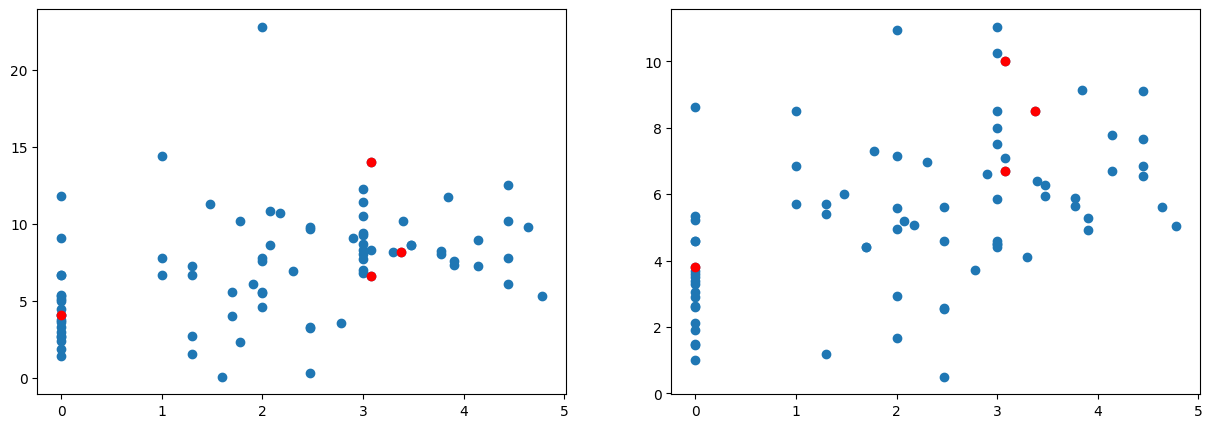

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
per_ed = per_concat[per_concat['BP Distribution Type'] == 'ME']
ax[0].scatter(per_concat['log_dt'], per_concat['SBP Error STD'])
ax[0].scatter(per_ed['log_dt'], per_ed['SBP Error STD'], c='r')
ax[1].scatter(per_concat['log_dt'], per_concat['DBP Error STD'])
ax[1].scatter(per_ed['log_dt'], per_ed['DBP Error STD'], c='r')

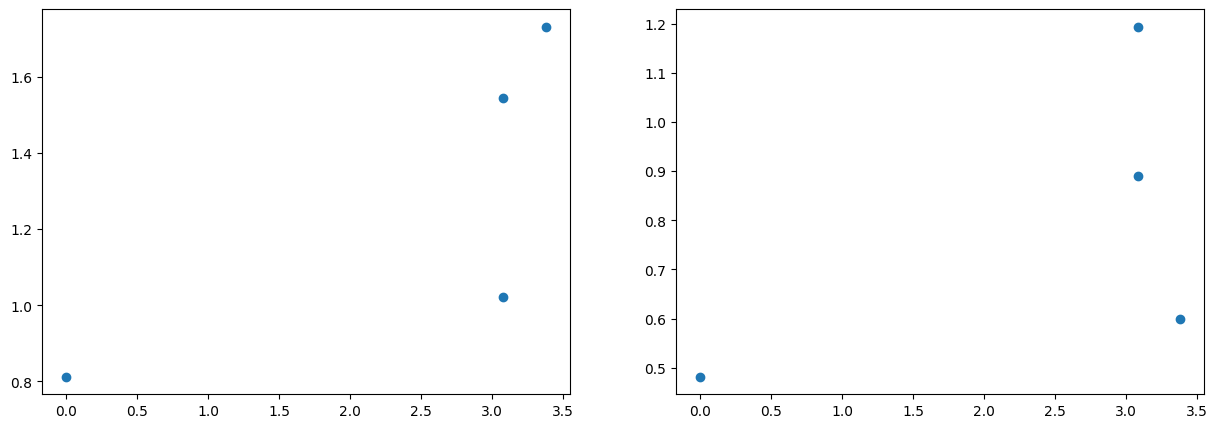

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].scatter(per_ed['log_dt'], per_ed['SBP ED'])
ax[1].scatter(per_ed['log_dt'], per_ed['DBP ED'])

## Benchmarks

In [25]:
benchmark_data = pd.read_excel('metadata.xlsx', sheet_name='Benchmarks')
benchmark_key = pd.read_excel('metadata.xlsx', sheet_name='Benchmark Key')

# benchmark_data['SBP ED'] = benchmark_data['SBP ED'].fillna('Incomplete')
# benchmark_data['DBP ED'] = benchmark_data['DBP ED'].fillna('Incomplete')
benchmark_data['ED'] = benchmark_data['SBP ED'].astype(str) + '/' + benchmark_data['DBP ED'].astype(str)
# benchmark_data['ED'] = benchmark_data['ED'].replace('N/A', 'Incompatible')

In [26]:
def assign_name(d, key):
    if d == d:
        row = key[key['Benchmark Item Name'] == d]
        return row['Display Name'].values[0]
    else:
        pass

cols = ['Filter', 'Estimator']
for col in cols:
    benchmark_data[col] = benchmark_data[col].apply(assign_name, args=(benchmark_key, ))

In [27]:
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Category10_3
from bokeh.models import Legend, LegendItem

output_file('./_includes/replicated_ed_scatter.html')

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 10px"> Dataset: @{Dataset} </span> <br>
                <span style="font-size: 10px"> Filter: @{Filter} </span> <br>
                <span style="font-size: 10px"> Estimator: @{Estimator} </span> <br>
                <span style="font-size: 10px"> Reported SBP/DBP ED: @{Reported SBP ED} / @{Reported DBP ED}</span> <br>
                <span style="font-size: 10px"> Replicated SBP/DBP ED: @{SBP ED} / @{DBP ED}</span> <br>
            </div>
        </div>
        """
    )

p1 = figure(title = "Reported vs Replicated ED for SBP and DBP", background_fill_color="#fafafa", plot_width=400, plot_height=400, toolbar_location='above', tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p1.xaxis.axis_label = 'Reported SBP ED'
p1.yaxis.axis_label = 'Replicated SBP ED'
p2 = figure(title = "", background_fill_color="#fafafa", plot_width=485, plot_height=400, toolbar_location='above', tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p2.xaxis.axis_label = 'Reported DBP ED'
p2.yaxis.axis_label = 'Replicated DBP ED'

cs = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
shapes = ['circle', 'triangle', 'diamond', 'plus']
dset_unique = benchmark_data['Dataset'].unique()
filter_unique = benchmark_data['Filter'].unique()
color_dict = {}
for i in range(len(dset_unique)):
    color_dict[dset_unique[i]] = cs[i]
shape_dict = {}
for i in range(len(filter_unique)):
    shape_dict[filter_unique[i]] = shapes[i]
benchmark_data['color'] = benchmark_data['Dataset'].apply(lambda x: color_dict[x])
benchmark_data['shape'] = benchmark_data['Filter'].apply(lambda x: shape_dict[x])

legend_it = []
for i in range(len(dset_unique)):
    d = benchmark_data[benchmark_data['Dataset'] == dset_unique[i]]
    c1 = p1.scatter('Reported SBP ED', 'SBP ED', source=ColumnDataSource(d), size=12, color='color', marker='shape')
    c2 = p2.scatter('Reported DBP ED', 'DBP ED', source=ColumnDataSource(d), size=12, color='color', marker='shape')
    legend_it.append((dset_unique[i], [c1, c2]))
legend = Legend(items=legend_it)
legend.click_policy='hide'
p2.add_layout(legend, 'right')
p2.legend.title = 'Dataset'

show(row([p1, p2]))

In [28]:
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Category10_3
from bokeh.models import Legend, LegendItem

output_file('./_includes/replicated_ed_diff_scatter.html')

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 10px"> Dataset: @{Dataset} </span> <br>
                <span style="font-size: 10px"> Filter: @{Filter} </span> <br>
                <span style="font-size: 10px"> Estimator: @{Estimator} </span> <br>
                <span style="font-size: 10px"> Reported SBP/DBP ED: @{Reported SBP ED} / @{Reported DBP ED}</span> <br>
                <span style="font-size: 10px"> Replicated SBP/DBP ED: @{SBP ED} / @{DBP ED}</span> <br>
                <span style="font-size: 10px"> SBP/DBP ED Difference: @{SBP ED Difference} / @{DBP ED Difference} </span> <br>
            </div>
        </div>
        """
    )

p1 = figure(title = "Replicated-Reported ED Difference for SBP and DBP", background_fill_color="#fafafa", plot_width=550, plot_height=400, toolbar_location='above', tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p1.xaxis.axis_label = 'Replicated DBP ED - Reported DBP ED'
p1.yaxis.axis_label = 'Replicated SBP ED - Reported SBP ED'

cs = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
shapes = ['circle', 'triangle', 'diamond', 'plus']
dset_unique = benchmark_data['Dataset'].unique()
filter_unique = benchmark_data['Filter'].unique()
color_dict = {}
for i in range(len(dset_unique)):
    color_dict[dset_unique[i]] = cs[i]
shape_dict = {}
for i in range(len(filter_unique)):
    shape_dict[filter_unique[i]] = shapes[i]
benchmark_data['color'] = benchmark_data['Dataset'].apply(lambda x: color_dict[x])
benchmark_data['shape'] = benchmark_data['Filter'].apply(lambda x: shape_dict[x])
benchmark_data['SBP ED Difference'] = benchmark_data['SBP ED'].astype(float) - benchmark_data['Reported SBP ED'].astype(float)
benchmark_data['DBP ED Difference'] = benchmark_data['DBP ED'].astype(float) - benchmark_data['Reported DBP ED'].astype(float)

legend_it = []
for i in range(len(dset_unique)):
    d = benchmark_data[benchmark_data['Dataset'] == dset_unique[i]]
    c1 = p1.scatter('DBP ED Difference', 'SBP ED Difference', source=ColumnDataSource(d), size=12, color='color', marker='shape')
    legend_it.append((dset_unique[i], [c1]))
legend = Legend(items=legend_it)
legend.click_policy='hide'
p1.add_layout(legend, 'right')
p1.legend.title = 'Dataset'

show(p1)

In [29]:
d = benchmark_data.copy().dropna(how='all')
def assign_url(d, key):
    if d == d:
        row = key[key['Display Name'] == d]
        return '<a href="' + row['URL'].values[0] + '">' + row['Display Name'].values[0] + '</a>'
    else:
        pass

cols = ['Filter', 'Estimator']
for col in cols:
    d[col] = d[col].apply(assign_url, args=(benchmark_key, ))

d = d.pivot(index=['Dataset', 'Filter'], columns='Estimator', values='ED').T
d

Dataset                                                                                                                        MIMIC  \
Filter                                             <a href="https://ieeexplore.ieee.org/document/7491263">Kachuee et al., (2017)</a>   
Estimator                                                                                                                              
<a href="http://dx.doi.org/10.1364/boe.444535">...                                           1.0/0.99                                  
<a href="https://ieeexplore.ieee.org/document/8...                                          1.05/1.02                                  
<a href="https://www.nature.com/articles/s41598...                                            1.0/1.0                                  
<a href="https://www.sciencedirect.com/science/...                                            1.0/1.0                                  

Dataset                                                                                                                                  \
Filter                                             <a href="https://ieeexplore.ieee.org/document/8938751">Hasandazeh et al., (2019)</a>   
Estimator                                                                                                                                 
<a href="http://dx.doi.org/10.1364/boe.444535">...                                           1.4/1.47                                     
<a href="https://ieeexplore.ieee.org/document/8...                                           1.45/1.4                                     
<a href="https://www.nature.com/articles/s41598...                                            nan/nan                                     
<a href="https://www.sciencedirect.com/science/...                                            nan/nan                                     

Dataset                                                                                                                    PPG-BP  \
Filter                                             <a href="https://www.nature.com/articles/sdata201820">Liang et al., (2018)</a>   
Estimator                                                                                                                           
<a href="http://dx.doi.org/10.1364/boe.444535">...                                          1.09/0.97                               
<a href="https://ieeexplore.ieee.org/document/8...                                           1.13/1.0                               
<a href="https://www.nature.com/articles/s41598...                                            nan/nan                               
<a href="https://www.sciencedirect.com/science/...                                            nan/nan                               

Dataset                                                                                                                                   VitalDB  
Filter                                             <a href="https://iopscience.iop.org/article/10.1088/1361-6579/abf889">Zhang et al., (2021)</a>  
Estimator                                                                                                                                          
<a href="http://dx.doi.org/10.1364/boe.444535">...                                          1.06/1.04                                              
<a href="https://ieeexplore.ieee.org/document/8...                                          1.05/1.08                                              
<a href="https://www.nature.com/articles/s41598...                                          1.06/1.03                                              
<a href="https://www.sciencedirect.com/science/...                                          1.05/1.08

In [30]:
d.reset_index().to_html('./_includes/benchmark_table.html', index=False, render_links=True, table_id='btable', escape=False)

# Dataset Table

In [31]:
data = pd.read_excel('metadata.xlsx', sheet_name='Publicly Available Datasets')

In [32]:
data['Dataset Name'] = make_clickable(data['Dataset Name'], data['Dataset URL'])
data['Article URL'] = make_clickable('Article URL', data['Dataset URL'])

In [33]:
data[['Dataset Name', 'Article URL', 'Sensor Data', 'Number of Subjects', 'Study Characteristics', 'BP Distribution SBP', 'BP Distribution DBP', 'Access', 'Notes']].to_html('./_includes/dataset_table.html', index=False, render_links=True, table_id='dtable', escape=False)

In [34]:
data

,Dataset Name,Dataset URL,Article URL,Study Characteristics,Number of Subjects,Subject Characteristics,Sensor Data,BP Distribution SBP,BP Distribution DBP,Access,Notes
0,"<a href=""https://physionet.org/content/mimic3w...",https://physionet.org/content/mimic3wdb/1.0/,"<a href=""https://physionet.org/content/mimic3w...",observational study,30000,diseased (ICU patients),record dependent. typically includes one or mo...,variable depending on segmentation technique,variable depending on segmentation technique,open access,MIMIC-III Waveform Database Matched Subset ava...
1,"<a href=""https://outbox.eait.uq.edu.au/uqdliu3...",https://outbox.eait.uq.edu.au/uqdliu3/uqvitals...,"<a href=""https://outbox.eait.uq.edu.au/uqdliu3...",observational study,32,diseased (surgical patients),"ECG, PPG and ABP waveform",variable depending on segmentation technique,variable depending on segmentation technique,open access,NaN
2,"<a href=""https://doi.org/10.6084/m9.figshare.5...",https://doi.org/10.6084/m9.figshare.5459299,"<a href=""https://doi.org/10.6084/m9.figshare.5...",observational study,219,healthy+diseased,PPG and cuff BP measurements,127.95±20.38,71.85±11.11,open access,PPG-BP has waveforms containing 2-3 peaks. Som...
3,"<a href=""https://github.com/microsoft/aurorabp...",https://github.com/microsoft/aurorabp-sample-data,"<a href=""https://github.com/microsoft/aurorabp...","observational study (supine, seated, 24 hour)",1125,healthy+diseased,"ECG, smartwatch (ECG and PPG), tonometer, PPG,...",1.72±10.3 (change),1.62±8.12 (change),credentialed access,NaN
4,"<a href=""https://physionet.org/content/pulse-t...",https://physionet.org/content/pulse-transit-ti...,"<a href=""https://physionet.org/content/pulse-t...",interventional study (before and after exercise),22,healthy,"ECG, PPG and cuff BP","117.43±14.00 (start), 117.12±13.67 (end)","75.50±8.97 (start), 75.56±8.55 (end)",open access,NaN
5,"<a href=""https://github.com/arianesasso/aime-2...",https://github.com/arianesasso/aime-2020,"<a href=""https://github.com/arianesasso/aime-2...",interventional study (stress test) and observa...,12,diseased (hypertensive),PPG and cuff BP,139.69±14.74,105.67±11.35,credentialed access,NaN
6,"<a href=""https://www.kaggle.com/datasets/mkach...",https://www.kaggle.com/datasets/mkachuee/nonin...,"<a href=""https://www.kaggle.com/datasets/mkach...",interventional study (exercise),26,healthy,"PCG, ECG, PPG and cuff BP",134.79±26.94,70.72±13.20,open access,NaN
7,"<a href=""https://vitaldb.net/dataset/"">VitalDB...",https://vitaldb.net/dataset/,"<a href=""https://vitaldb.net/dataset/"">Article...",observational study,6388,diseased (patients under ananesthesia),"196 intraoperative monitoring parameters, 73 p...",variable depending on subset,variable depending on subset,open access,"VitalDB has both ECG and PPG signals. However,..."
8,"<a href=""https://physionet.org/content/charisd...",https://physionet.org/content/charisdb/1.0.0/,"<a href=""https://physionet.org/content/charisd...",observational study,29,diseased (ICU patients),"ECG, ABP waveform and Intracranial Pressure (ICP)",variable depending on segmentation technique,variable depending on segmentation technique,open access,NaN
